# Problem set 4: Analyzing data

[<img src="https://mybinder.org/badge_logo.svg">](https://mybinder.org/v2/gh/NumEconCopenhagen/exercises-2020/master?urlpath=lab/tree/PS4/problem_set_4.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import pydst
dst = pydst.Dst(lang='en')

# Tasks

## Import national account data from Denmark Statistics

Consider the following dictionary definitions:

In [2]:
columns_dict = {}
columns_dict['TRANSAKT'] = 'variable'
columns_dict['PRISENHED'] = 'unit'
columns_dict['TID'] = 'year'
columns_dict['INDHOLD'] = 'value'

var_dict = {} # var is for variable
var_dict['P.1 Output'] = 'Y'
var_dict['P.3 Final consumption expenditure'] = 'C'
var_dict['P.3 Government consumption expenditure'] = 'G'
var_dict['P.5 Gross capital formation'] = 'I'
var_dict['P.6 Export of goods and services'] = 'X'
var_dict['P.7 Import of goods and services'] = 'M'

unit_dict = {}
unit_dict['2010-prices, chained values'] = 'real'
unit_dict['Current prices'] = 'nominal'

**Step 1:** Download all of table `nah1`.

In [3]:
# hint, nah1 = dst.get_data(table_id = '?', variables={'TRANSAKT':[?], 'PRISENHED':[?], 'TID':[?]})

**Step 2:** Rename the columns using `columns_dict` and replace data using `var_dict` and `unit_dict`.

In [4]:
# hint, nah1_true.rename(?,inplace=True)

# for key,value in var_dict.items():
#   nah1.variable.replace(?)

#for key,value in unit_dict.items():
#   nah1.unit.replace(?)

**Step 3:** Only keep rows where the variable is in `[Y, C, G, I, X, M]`. Afterwards convert the `value` column to a float.

In [5]:
# write you code here
# nah1.value = nah1.value.astype('float')

**Step 4:** Discuss what the following summary statistics show.

In [6]:
# nah1_true.groupby(['variable','unit']).describe()

**Answer:**

In [7]:
# a. load
nah1_true = dst.get_data(table_id = 'NAH1', variables={'TRANSAKT':['*'], 'PRISENHED':['*'], 'TID':['*']})

# b. rename and replace
nah1_true.rename(columns=columns_dict,inplace=True)

# c. replace data
for key,value in var_dict.items():
   nah1_true.variable.replace(key,value,inplace=True)

for key,value in unit_dict.items():
   nah1_true.unit.replace(key,value,inplace=True)

# d. keep if in var_dict
I = False
for key,value in var_dict.items():
    I = I | (nah1_true.variable == value)
nah1_true = nah1_true[I]
   
# e. convert values to numeric
nah1_true.value = nah1_true.value.astype('float')

# d. summary statistics
nah1_true.groupby(['variable','unit']).describe()

year                                                       \
                 count    mean        std     min      25%     50%      75%   
variable unit                                                                 
C        nominal  54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
         real     54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
G        nominal  54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
         real     54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
I        nominal  54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
         real     54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
M        nominal  54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
         real     54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
X        nominal  54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
         real     54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
Y        nominal  54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   
         real     54.0  1992.5  15.732133  1966.0  1979.25  1992.5  2005.75   

                         value                                         \
                     max count          mean           std        min   
variable unit                                                           
C        nominal  2019.0  54.0  7.524963e+05  4.946441e+05    62576.0   
         real     2019.0  54.0  1.041583e+06  2.693538e+05   549491.0   
G        nominal  2019.0  54.0  2.548865e+05  1.760344e+05    14768.0   
         real     2019.0  54.0  3.654870e+05  1.005781e+05   171307.0   
I        nominal  2019.0  54.0  2.180079e+05  1.489821e+05    21134.0   
         real     2019.0  54.0  2.696939e+05  1.028857e+05   127631.0   
M        nominal  2019.0  54.0  4.170815e+05  3.470709e+05    24406.0   
         real     2019.0  54.0  4.658273e+05  3.034730e+05   112171.0   
X        nominal  2019.0  54.0  4.683807e+05  3.959874e+05    23110.0   
         real     2019.0  54.0  5.443007e+05  3.450938e+05   123594.0   
Y        nominal  2019.0  54.0  1.739697e+06  1.215356e+06   144582.0   
         real     2019.0  54.0  2.286401e+06  7.956098e+05  1089347.0   

                                                                
                         25%        50%         75%        max  
variable unit                                                   
C        nominal   300574.00   690838.5  1190102.50  1638006.0  
         real      847003.50   985547.0  1310552.75  1507829.0  
G        nominal    95488.75   228970.0   402510.75   558036.0  
         real      302889.25   341629.5   450260.50   524670.0  
I        nominal    77927.00   176581.0   328382.75   527188.0  
         real      182790.25   231070.0   347427.75   479365.0  
M        nominal   120802.25   278773.0   716919.75  1140654.0  
         real      212214.25   325342.0   765015.25  1075868.0  
X        nominal   113738.25   340299.5   796829.25  1296947.0  
         real      235550.00   436267.0   872649.00  1220323.0  
Y        nominal   629505.50  1496460.0  2867488.25  4079754.0  
         real     1599582.00  2094282.0  3096363.75  3707849.0

## Merge with population data from Denmark Statistics

Load population data from Denmark Statistics:

In [8]:
pop = dst.get_data(table_id = 'FT', variables={'HOVEDDELE':['*'], 'TID':['*']})
pop.rename(columns={'TID':'year','INDHOLD':'population'},inplace=True)
I = pop.HOVEDDELE == 'All Denmark'
pop =  pop.loc[I,['year','population']]
pop.head()

,year,population
0,1769,797584
8,1787,841806
16,1801,929001
24,1834,1230964
32,1840,1289075


**Question 1:** Merge the population and the national account data, so there is a new column called `population`. Use the **merge function**.

In [9]:
# hint, merged = pd.merge(?,?,how='?',on=[?])
# merged_true.tail(10)

**Answer:**

In [10]:
merged_true = pd.merge(nah1_true,pop,how='left',on=['year'])
merged_true.tail(10)

,variable,unit,year,value,population
638,C,real,2019,1507829.0,5806081.0
639,C,nominal,2019,1638006.0,5806081.0
640,G,real,2019,524670.0,5806081.0
641,G,nominal,2019,558036.0,5806081.0
642,I,real,2019,479365.0,5806081.0
643,I,nominal,2019,527188.0,5806081.0
644,X,real,2019,1220323.0,5806081.0
645,X,nominal,2019,1296947.0,5806081.0
646,M,real,2019,1075868.0,5806081.0
647,M,nominal,2019,1140654.0,5806081.0


**Question 2:** Merge the population on again, so there is a new column called `population_alt`. Use the **join method**.

In [11]:
# pop_with_index = pop.set_index(?)
# pop_with_index.rename(columns={'population':'population_alt'},inplace=True)
# merged_with_index = merged.set_index(?)
# merged_alt = merged_with_index.join(?)
# merged_alt.tail(10)

**Answer:**

In [12]:
pop_with_index = pop.set_index('year')
pop_with_index.rename(columns={'population':'population_alt'},inplace=True)
merged_true_with_index = merged_true.set_index('year')
merged_true_alt = merged_true_with_index.join(pop_with_index)
merged_true_alt.tail(10)

,variable,unit,value,population,population_alt
year,,,,,
2019,C,real,1507829.0,5806081.0,5806081.0
2019,C,nominal,1638006.0,5806081.0,5806081.0
2019,G,real,524670.0,5806081.0,5806081.0
2019,G,nominal,558036.0,5806081.0,5806081.0
2019,I,real,479365.0,5806081.0,5806081.0
2019,I,nominal,527188.0,5806081.0,5806081.0
2019,X,real,1220323.0,5806081.0,5806081.0
2019,X,nominal,1296947.0,5806081.0,5806081.0
2019,M,real,1075868.0,5806081.0,5806081.0


## Split-apply-combine-(plot)

Consider the following **split-apply-combine-plot:**

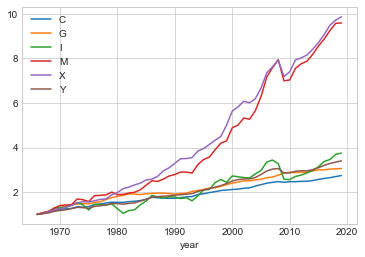

In [13]:
# a. split
nah1_true_grouped = nah1_true.groupby(['variable','unit'])
nah1_true_grouped_first = nah1_true_grouped.value.first()
nah1_true_grouped_first.name = 'first'

# b. apply
nah1_true.set_index(['variable','unit','year'],inplace=True)
nah1_true = nah1_true.join(nah1_true_grouped_first,how='left',on=['variable','unit'])
nah1_true.reset_index(inplace=True)

# c. combine
nah1_true['indexed'] = nah1_true['value']/nah1_true['first']

# d. plot
def plot(df):
    df_indexed = df.set_index('year')
    I = df_indexed.unit == 'real'
    df_indexed[I].groupby(['variable'])['indexed'].plot(legend=True);
    
plot(nah1_true)

**Question** Implement the same split-apply-combine as above using `transform`.

In [14]:
def first(x): # select the first element in a series
    return x.iloc[0]

# nah1_alt = nah1_final.copy()
# grouped = nah1_alt.groupby(?)
#nah1_alt[?] = ?.transform(lambda x: ?)
#nah1_alt.head()

**Answer:**

In [15]:
nah1_true_alt = nah1_true.copy()
grouped = nah1_true_alt.groupby(['variable','unit'])
nah1_true_alt['index_transform'] = grouped['value'].transform(lambda x: x/first(x))
nah1_true_alt.head()

,variable,unit,year,value,first,indexed,index_transform
0,Y,real,1966,1089347.0,1089347.0,1.0,1.0
1,Y,nominal,1966,144582.0,144582.0,1.0,1.0
2,C,real,1966,549491.0,549491.0,1.0,1.0
3,C,nominal,1966,62576.0,62576.0,1.0,1.0
4,G,real,1966,171307.0,171307.0,1.0,1.0


# Problem: The Housing market


## Housing data

**Note:** The file `data/bm010_parcel.xlsx` has been downloaded from http://rkr.statistikbank.dk/201.

**Question:** Go through the cell below and ensure you understand ALL commands.

In [16]:
# a. load data
prices = pd.read_excel('data/bm010_parcel.xlsx', skiprows=2)
prices.rename(columns={'Unnamed: 2': 'municipality'}, inplace=True)

# b. delete columns
del prices['Unnamed: 0']
del prices['Unnamed: 1']

# c. rename time columns: 1992K1 -> price19921
time_dict = {} 
for y in range(1992,2018+1): 
    for k in range(1,4+1): 
        str_from = f'{y}K{k}'
        str_to   = f'price{y}{k}'
        time_dict[str_from] = str_to
prices = prices.rename(columns = time_dict)        

# d. drop missing
prices = prices.dropna()

# e. convert to long
prices_long = pd.wide_to_long(prices, stubnames='price', i='municipality', j='year_quarter')
prices_long.reset_index(inplace=True)

# f. drop missing and convert to float
I = prices_long.loc[prices_long.price == '..']
prices_long.drop(I.index, inplace=True)
prices_long.price = prices_long.price.astype('float')

# g. create date variable
prices_long['d'] = (prices_long.year_quarter.astype(str).str[:4] # grab the year, first four digits
          + 'Q' # add the letter Q 
          + prices_long.year_quarter.astype(str).str[4]) # the quarter (fifth digit)
prices_long['date'] = pd.to_datetime(prices_long.d)

# h. cleanup 
del prices_long['year_quarter']
del prices_long['d']

prices_long.head()

,municipality,price,date
0,Hele landet,4021.0,1992-01-01
1,Region Hovedstaden,5836.0,1992-01-01
2,Landsdel København by,5658.0,1992-01-01
3,København,5355.0,1992-01-01
4,Frederiksberg,5183.0,1992-01-01


## Population data

**Question:** Go through the cell below and ensure you understand ALL commands.

In [17]:
# a. load data
pop = dst.get_data(table_id='FOLK1A', variables={'Alder':['IALT'], 'CIVILSTAND':['TOT'], 'Køn':['TOT'], 'Tid':['*'], 'OMRÅDE':['*']})

# b. drop and rename columns
for v in ['ALDER', 'CIVILSTAND', 'KØN']: 
    del pop[v]
pop = pop.rename(columns = {'INDHOLD':'population', 'OMRÅDE': 'municipality'})

# c. drop non-municipalities
for val in ['Region', 'All']: 
    I = pop['municipality'].str.contains(val)
    pop.drop(pop[I].index, inplace=True)

# d. convert to date
pop['date'] = pd.to_datetime(pop.TID)
del pop['TID']

pop.head()

,municipality,population,date
0,Brøndby,35050,2015-01-01
1,Brøndby,34084,2012-01-01
2,Hvidovre,51270,2012-10-01
3,Gentofte,75365,2016-04-01
4,Brøndby,33856,2010-07-01


## Analysis

**Problem:** Analyze the co-variation betwen population growth and house price growth. Reproduce the graphs below. 

**Hint:** For the second one consider the `agg` method (similar to but different from `transform`, Google it).

In [18]:
# write your code here 

**Answer:**

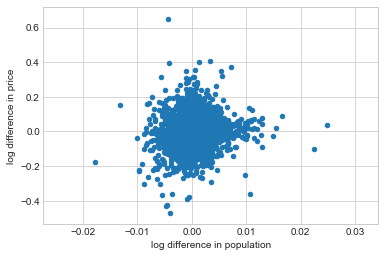

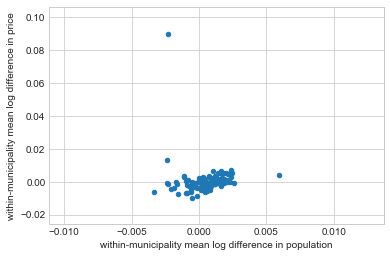

In [19]:
# a. merge
full = pd.merge(pop, prices_long, on=['date','municipality'], how='left')
full.sort_values(['municipality','date'], inplace=True)

# b. take logs
full['log_population'] =  np.log(full['population'])
full['log_price'] =  np.log(full['price'])

# c. figur 1: log differences
ax = full.groupby('municipality').diff(1).plot(x = 'log_population', y = 'log_price', kind = 'scatter'); 
ax.set_xlabel('log difference in population') 
ax.set_ylabel('log difference in price')

# c. figur 2: mean log differences
ax = full.groupby('municipality').agg(lambda x: np.mean(x.diff())).plot(x = 'log_population', y = 'log_price', kind = 'scatter'); 
ax.set_xlabel('within-municipality mean log difference in population')
ax.set_ylabel('within-municipality mean log difference in price'); 